In [1]:
import glob
import geopandas as gpd
import os
import sys
import rasterio as rio
from rasterio.features import rasterize
import rasterio.windows
import pandas as pd
import numpy as np
from tqdm import tqdm
from joblib import load

from shapely.geometry import LineString, Polygon

sys.path.append('/home/sushen/marine_debris_semester_project')
# from model.random_forest.random_forest import get_random_forest

from harmonization_scripts.feature_extraction import calculate_indices, calculate_texture
from data.utils_file import pad

In [2]:
def line_is_closed(linestringgeometry):
    coordinates = np.stack(linestringgeometry.xy).T
    first_point = coordinates[0]
    last_point = coordinates[-1]
    return bool((first_point == last_point).all())

In [2]:
# Indicates which RF Classifier we will use, 0 = old classes, 1 = new classes
classifier_index = 1

# Folder contents paths
list_tif = glob.glob("/data/sushen/marinedebris/floatingobjects/scenes/*.tif")
list_shp = glob.glob("/data/sushen/marinedebris/floatingobjects/shapefiles/*.shp")
output_paths = ['/data/sushen/marinedebris/project/floObj_shapefiles_old_classes/', '/data/sushen/marinedebris/project/floObj_shapefiles_new_classes/']
output_path = output_paths[classifier_index]

# Remove l2a files
list_tif = [ x for x in list_tif if "l2a" not in x ]

# Random forest Classifier
cl_paths = ['/data/sushen/marinedebris/project/rf_classifier_old_classes.joblib', '/data/sushen/marinedebris/project/rf_classifier_new_classes.joblib']
cl_path = cl_paths[classifier_index]
rf_classifier = load(cl_path)

In [3]:
print(list_tif)

['/data/sushen/marinedebris/floatingobjects/scenes/accra_20181031.tif', '/data/sushen/marinedebris/floatingobjects/scenes/biscay_20180419.tif', '/data/sushen/marinedebris/floatingobjects/scenes/danang_20181005.tif', '/data/sushen/marinedebris/floatingobjects/scenes/kentpointfarm_20180710.tif', '/data/sushen/marinedebris/floatingobjects/scenes/kolkata_20201115.tif', '/data/sushen/marinedebris/floatingobjects/scenes/lagos_20190101.tif', '/data/sushen/marinedebris/floatingobjects/scenes/lagos_20200505.tif', '/data/sushen/marinedebris/floatingobjects/scenes/london_20180611.tif', '/data/sushen/marinedebris/floatingobjects/scenes/longxuyen_20181102.tif', '/data/sushen/marinedebris/floatingobjects/scenes/mandaluyong_20180314.tif', '/data/sushen/marinedebris/floatingobjects/scenes/neworleans_20200202.tif', '/data/sushen/marinedebris/floatingobjects/scenes/panama_20190425.tif', '/data/sushen/marinedebris/floatingobjects/scenes/portalfredSouthAfrica_20180601.tif', '/data/sushen/marinedebris/floa

In [25]:
# Locate path of scene and their shapefiles from the lists
image_index = 0
tif_file_path = list_tif[image_index]
shp_file_path = list_shp[image_index]

shp_filename = os.path.basename(shp_file_path)
print(shp_filename)

lines_shp_filename = shp_filename.split('.shp')[0] + '_lines.shp'
polygons_shp_filename = shp_filename.split('.shp')[0] + '_polygons.shp'

output_lines_shp_file_path = os.path.join(output_path, lines_shp_filename)
output_polygons_shp_file_path = os.path.join(output_path, polygons_shp_filename)

print(output_lines_shp_file_path)
print(output_polygons_shp_file_path)


accra_20181031.shp
/data/sushen/marinedebris/project/floObj_shapefiles_new_classes/accra_20181031_lines.shp
/data/sushen/marinedebris/project/floObj_shapefiles_new_classes/accra_20181031_polygons.shp


In [26]:
# Rasterio Image opening
with rio.open(tif_file_path, "r") as src:
    crs = src.crs
    transform = src.transform

# Open geopandas dataframe and use corresponding CRS
gdf = gpd.read_file(shp_file_path)
gdf = gdf.to_crs(crs)
print(len(gdf))

118


85
33


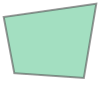

In [27]:
is_closed_line = gdf.geometry.apply(line_is_closed)

gdf_lines = gdf.loc[~is_closed_line]
print(len(gdf_lines))

gdf_polygons = gdf.loc[is_closed_line]
gdf_polygons['geometry'] = gdf_polygons.geometry.apply(Polygon)
print(len(gdf_polygons))

gdf_polygons['geometry'].iloc[0]


In [20]:
def gdf_class_prediction(gdf, tif_file_path, transform, rf_classifier):
    # Iterate of every geometry object and get the pixels
    imagesize = 16*10
    geometry_classes = []

    for j in tqdm(np.arange(len(gdf))):
        row = gdf.iloc[j]

        minx, miny, maxx, maxy = row.geometry.centroid.buffer(imagesize // 2).bounds
        window = rasterio.windows.from_bounds(minx, miny, maxx, maxy, transform = transform)
        width = int(window.width)
        height = int(window.height)

        # Open the scene using the window
        with rio.open(tif_file_path, "r") as src_crop:
                transform_crop = src_crop.window_transform(window)
                image_crop = src_crop.read(window=window)
        
        # Remove unused bands 
        image_crop = np.delete(image_crop, [9, 10], axis = 0)

        # Create a 2d mask and keep only pixels of interest
        geometry_object = gdf.iloc[[j]].geometry
        mask_2d = rasterize(geometry_object, all_touched=True,
                            transform=transform_crop, out_shape=(height, width))

        # Protect images and mask with padding if an geometric object too close to the boundary
        image_crop, mask_2d = pad(image_crop, mask_2d, imagesize // 10)

        # Calculate indices & textures
        indices = calculate_indices(image_crop)
        textures = calculate_texture(image_crop)

        # Reorder axis
        image_crop = np.moveaxis(image_crop, (0, 1, 2), (2, 0, 1))
        indices = np.moveaxis(indices, (0, 1, 2), (2, 0, 1))
        textures = np.moveaxis(textures, (0, 1, 2), (2, 0, 1))
        
        # Stacking features and reshaping into a 2d array of shape [#pixel, #bands]
        features = np.dstack((image_crop, indices, textures))
        sz1 = features.shape[0]
        sz2 = features.shape[1]
        features = np.reshape(features, (sz1*sz2, -1)) 
        
        # Apply mask
        mask_2d = np.reshape(mask_2d, sz1*sz2)
        bool_mask_2d = mask_2d > 0 
        geometry_features = features[bool_mask_2d, :]

        # Protection if for some odd reason list of pixels to predict is empty
        if geometry_features.size == 0:
            geometry_classes.append('Unresolved error')
            continue

        # Prediction of pixels in geometry object
        prediction = rf_classifier.predict(geometry_features)
        values, counts = np.unique(prediction, return_counts=True)
        ind = np.argmax(counts)
        predicted_class = values[ind]

        # Append prediction to the list
        geometry_classes.append(predicted_class)
    
    return geometry_classes

In [21]:
# Shapefile predictions
lines_geometry_classes = gdf_class_prediction(gdf_lines, tif_file_path, transform, rf_classifier)
if len(gdf_polygons) > 0:
    polygons_geometry_classes = gdf_class_prediction(gdf_polygons, tif_file_path, transform, rf_classifier)

100%|██████████| 41/41 [00:07<00:00,  5.82it/s]


In [22]:
# Add predicted marida class to the GeoDataFrame and save it
gdf_lines['marida_cla'] = lines_geometry_classes # there is a 10 character limit for gpd column names
gdf_lines['img_path'] = tif_file_path
gdf_lines.to_file(output_lines_shp_file_path)

if len(gdf_polygons) > 0:
    gdf_polygons['marida_cla'] = polygons_geometry_classes # there is a 10 character limit for gpd column names
    gdf_polygons['img_path'] = tif_file_path
    gdf_polygons.to_file(output_polygons_shp_file_path)

In [23]:
gdf_test = gpd.read_file(output_lines_shp_file_path)
gdf_test.sample(5)
gdf_test['marida_cla'].value_counts()

Water               31
Waves                9
Unresolved error     1
Name: marida_cla, dtype: int64

In [ ]:
# print(errors)
# df_test = pd.Series(classes)
# df_test.value_counts()

In [ ]:
# Iterate of every geometry object and get the pixels
imagesize = 16*10
geometry_classes = []

index = 0

row = gdf_lines.iloc[index]

minx, miny, maxx, maxy = row.geometry.centroid.buffer(imagesize // 2).bounds
window = rasterio.windows.from_bounds(minx, miny, maxx, maxy, transform = transform)
width = int(window.width)
height = int(window.height)

# Open the scene using the window
with rio.open(tif_file_path, "r") as src_crop:
        transform_crop = src_crop.window_transform(window)
        image_crop = src_crop.read(window=window)

# Remove unused bands 
image_crop = np.delete(image_crop, [9, 10], axis = 0)
print('Cropped image shape is:', image_crop.shape)

# Create a 2d mask and keep only pixels of interest
geometry_object = gdf_lines.iloc[[index]].geometry
print(geometry_object)
mask_2d = rasterize(geometry_object, all_touched=True,
                    transform=transform_crop, out_shape=(height, width))
print('Mask 2D shape is:', mask_2d.shape)

# Protect images and mask with padding if an geometric object too close to the boundary
image_crop, mask_2d = pad(image_crop, mask_2d, imagesize // 10)
print('After padding, image and mask shapes are:', image_crop.shape, mask_2d.shape)

# Calculate indices & textures
indices = calculate_indices(image_crop)
textures = calculate_texture(image_crop)
print('Indices and textures shapes are:', indices.shape, textures.shape)

# Reorder axis
image_crop = np.moveaxis(image_crop, (0, 1, 2), (2, 0, 1))
indices = np.moveaxis(indices, (0, 1, 2), (2, 0, 1))
textures = np.moveaxis(textures, (0, 1, 2), (2, 0, 1))

# Stacking features and reshaping into a 2d array of shape [#pixel, #bands]
features = np.dstack((image_crop, indices, textures))
sz1 = features.shape[0]
sz2 = features.shape[1]
features = np.reshape(features, (sz1*sz2, -1)) 

# Apply mask
mask_2d = np.reshape(mask_2d, sz1*sz2)
print(mask_2d)
bool_mask_2d = mask_2d > 0 
# print(bool_mask_2d)
geometry_features = features[bool_mask_2d, :]
# print(geometry_features.shape)

# Protection if for some odd reason list of pixels to predict is empty
if geometry_features.size == 0:
    geometry_classes.append('Unresolved error')

# Prediction of pixels in geometry object
prediction = rf_classifier.predict(geometry_features)
values, counts = np.unique(prediction, return_counts=True)
ind = np.argmax(counts)
predicted_class = values[ind]

# Append prediction to the list
geometry_classes.append(predicted_class)